# Forecasting sulfur concentrations

### 1) Importing libraries and functions

In [224]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import *


# from Data_sorting import Data_formatter_cycles

### 2) Arranging the scaled dataset as input and output

In [225]:
data = pd.read_excel('C:/Users/ADITYA/OneDrive - Imperial College London/Year 4/FYP/Final-year-project/VScode//Data/Dataset_scaled_denoised.xlsx')
data = data[data['I'] == 1.6]
X = data.iloc[1:,:9]
X = X.drop('I', axis = 1)
y = data.iloc[1:,11:16]

In [228]:
X_numpy = X.values
y_numpy = y.values

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_numpy, y_numpy, test_size=0.2, random_state=42)

In [230]:
print(X)

          S8_cur    S4_cur    S2_cur    S1_cur     V_cur    Sp_cur        EH  \
1       2.914558 -2.960002 -0.929154 -0.232859  3.965686 -0.925127  3.914506   
2       2.914450 -2.959872 -0.929154 -0.232859  3.953539 -0.925127  3.902619   
3       2.914342 -2.959743 -0.929154 -0.232858  3.941755 -0.925127  3.891043   
4       2.914234 -2.959613 -0.929154 -0.232858  3.930271 -0.925127  3.879762   
5       2.914126 -2.959483 -0.929154 -0.232858  3.919073 -0.925127  3.868761   
...          ...       ...       ...       ...       ...       ...       ...   
144008 -0.715584 -0.685340  2.665422 -0.146794 -0.871377  2.664142 -0.874464   
144009 -0.715584 -0.685383  2.665497 -0.146795 -0.871381  2.664216 -0.874468   
144010 -0.715584 -0.685426  2.665571 -0.146795 -0.871385  2.664290 -0.874473   
144011 -0.715584 -0.685469  2.665645 -0.146796 -0.871390  2.664365 -0.874477   
144012 -0.715584 -0.685512  2.665719 -0.146797 -0.871394  2.664439 -0.874481   

              EL  
1       4.072668  
2

In [231]:
model = Sequential()
model.add(Dense(8, activation='relu', input_dim = 8))
# model.add(Dense(6, activation='relu'))
# model.add(Dense(12,activation = 'relu'))
model.add(Dense(6,activation = 'relu'))
# model.add(Dense(10, activation='relu'))
model.add(Dense(5, activation='linear'))  # Output layer with a multiple neurons

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, epochs=20, batch_size=32)

Epoch 1/20
3601/3601 [==============================] - 3s 766us/step - loss: 0.0811
Epoch 2/20
3601/3601 [==============================] - 3s 801us/step - loss: 2.5748e-04
Epoch 3/20
3601/3601 [==============================] - 3s 763us/step - loss: 7.9632e-05
Epoch 4/20
3601/3601 [==============================] - 3s 827us/step - loss: 3.2214e-05
Epoch 5/20
3601/3601 [==============================] - 3s 757us/step - loss: 2.2100e-05
Epoch 6/20
3601/3601 [==============================] - 3s 760us/step - loss: 2.0133e-05
Epoch 7/20
3601/3601 [==============================] - 3s 789us/step - loss: 1.7340e-05
Epoch 8/20
3601/3601 [==============================] - 3s 766us/step - loss: 1.7342e-05
Epoch 9/20
3601/3601 [==============================] - 3s 762us/step - loss: 1.4842e-05
Epoch 10/20
3601/3601 [==============================] - 3s 766us/step - loss: 1.5007e-05
Epoch 11/20
3601/3601 [==============================] - 3s 789us/step - loss: 1.3982e-05
Epoch 12/20
3601/3601 [

### 4) Function to find Voltage

In [232]:
# Bisection method function
def f(V, EH, EL, scales):
    # Defined in the code
    iH0 = 10
    iL0 = 5
    R = 8.3145
    T = 298
    F = 96490
    ar = 0.96
    return 2 * iH0 * ar * np.sinh((2 * F / (R * T)) * (V - EH)) + 2 * iL0 * ar * np.sinh((2 * F / (R * T)) * (V - EL)) + scales.iloc[0,-1]

# Bisection method adjusted to accept EH, EL, and I
def bisection_method(V_a, V_b, EH, EL, scales, tol=1e-9, max_iter=10000):
    if f(V_a, EH, EL, scales) * f(V_b, EH, EL, scales) >= 0:
        print("Bisection method fails.")
        return None

    V_m = V_a
    for _ in range(max_iter):
        V_m = (V_a + V_b) / 2
        if f(V_m, EH, EL, scales) == 0 or np.abs(f(V_m, EH, EL, scales)) < tol:   # (V_b - V_a)/2
            return V_m

        if f(V_m, EH, EL, scales) * f(V_a, EH, EL, scales) < 0:
            V_b = V_m
        else:
            V_a = V_m

    return V_m  # Return the approximation of the root


def param_finder_BV(V,EH,EL):
    iH0 = 10
    iL0 = 5
    R = 8.3145
    T = 298
    F = 96490
    ar = 0.96
    iH = 2*iH0*ar*np.sinh((4*F*(V-EH))/(2*R*T))
    iL = 2*iL0*ar*np.sinh((4*F*(V-EL))/(2*R*T))
    return iH, iL



def next_prediction(prediction, scales):

    array = []

    S8,S4,S2,S1,Sp,EH,EL = param_finder_Nernst(prediction,scale)

    # Initial brackets (guesses) for V
    V_a, V_b = EH,EL # Adjust these values based on your knowledge of the possible range of V

    # Find V
    V = bisection_method(2.5, 2.1, EH, EL, scales)

    V = (V - scales.iloc[0,4])/scales.iloc[1,4]

    EH = (EH - scales.iloc[0,6])/scales.iloc[1,6]

    EL = (EL - scales.iloc[0,7])/scales.iloc[1,7]
    

    array.append(prediction[0][0])
    array.append(prediction[0][1])
    array.append(prediction[0][2])
    array.append(prediction[0][3])
    array.append(V)
    array.append(prediction[0][4])
    array.append(EH)
    array.append(EL)

    array = np.array([array])

    return array 




def param_finder_Nernst(prediction, scales):
    # Defined in the code
    EH0 = 2.35
    EL0 = 2.195
    iH0 = 10
    iL0 = 5
    R = 8.3145
    T = 298
    F = 96490
    fh = 0.7296
    fl = 0.06654
    ar = 0.96

    # Unscale the concentration values to find S8 - Sp
    S8 = (prediction[0][0] * scales.iloc[1,0]) + scales.iloc[0,0]
    S4 = (prediction[0][1] * scales.iloc[1,1]) + scales.iloc[0,1]
    S2 = (prediction[0][2] * scales.iloc[1,2]) + scales.iloc[0,2]
    S1 = (prediction[0][3] * scales.iloc[1,3]) + scales.iloc[0,3]
    Sp = (prediction[0][4] * scales.iloc[1,5]) + scales.iloc[0,5]

    # S8 = (prediction[0][0])
    # S4 = (prediction[0][1])
    # S2 = (prediction[0][2])
    # S1 = (prediction[0][3])
    # Sp = (prediction[0][4])

    # Unscaled EH, EL

    EH = EH0 + (((R*T)/(4*F))*np.log(fh*(S8/(S4**2))))
    EL = EL0 + (((R*T)/(4*F))*np.log(fl*(S4/((S1**2)*S2))))

    return S8,S4,S2,S1,Sp,EH,EL

1/1 [==============================] - 0s 21ms/step


[[ 2.7546859 -2.769393  -0.9266821 -0.2293309 -0.9226677]]
[[ 2.75468588 -2.76939297 -0.92668211 -0.2293309   1.91400032 -0.92266768
   2.26070541  1.29717577]]
1/1 [==============================] - 0s 22ms/step
[[ 2.9165182  -3.0766897  -0.73201364 -0.13523038 -0.72941625]]


C:\Users\ADITYA\AppData\Local\Temp\ipykernel_31656\1691894603.py:109: RuntimeWarning: invalid value encountered in log
  EL = EL0 + (((R*T)/(4*F))*np.log(fl*(S4/((S1**2)*S2))))


[[ 2.91651821 -3.07668972 -0.73201364 -0.13523038 -7.54742711 -0.72941625
   2.51738066         nan]]
1/1 [==============================] - 0s 21ms/step
[[-0.5664067   0.94813085 -0.46357673 -0.17386961 -0.46084213]]
[[-0.56640673  0.94813085 -0.46357673 -0.17386961  0.13103079 -0.46084213
   0.23810238 -0.09121848]]
1/1 [==============================] - 0s 19ms/step
[[-0.5385282   0.8875734  -0.41684574 -0.11473314 -0.41491067]]
[[-0.5385282   0.88757342 -0.41684574 -0.11473314  0.03790827 -0.41491067
   0.28284681 -0.44086467]]
1/1 [==============================] - 0s 17ms/step
[[-0.46859103  0.8001411  -0.4108134   0.02516338 -0.41064954]]
[[-0.46859103  0.8001411  -0.41081339  0.02516338 -0.0607061  -0.41064954
   0.36656613 -0.81381056]]


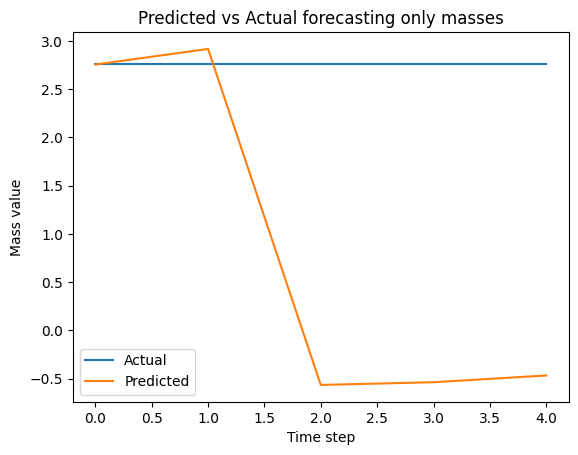

In [244]:
no_predictions = 5

start = 1500

input = np.array([X_numpy[start]])

output = []

scale = pd.read_excel('C:/Users/ADITYA/OneDrive - Imperial College London/Year 4/FYP/Final-year-project/VScode/Data/Scales.xlsx')

for i in range(no_predictions):
    
    next_prediction_array = model.predict(input)

    print(next_prediction_array)

    input = next_prediction(next_prediction_array, scale)

    print(input)

    output.append(input)


plot_actual = []

for j in range(no_predictions):
    plot_actual.append(X_numpy[no_predictions + start][0])

plt.plot(plot_actual, label = 'Actual')


# print(output)


mass = []
for i in range(len(output)):
    mass.append(output[i][0][0])

plt.plot(mass, label = 'Predicted')
plt.xlabel('Time step')
plt.ylabel('Mass value')
plt.title('Predicted vs Actual forecasting only masses')
plt.legend()

plt.show()

In [205]:
no_predictions = 3

start = 1500

input = np.array([X_numpy[start]])

output = []

scale = pd.read_excel('C:/Users/ADITYA/OneDrive - Imperial College London/Year 4/FYP/Final-year-project/VScode/Scales.xlsx')

# Defined in the code
EH0 = 2.35
EL0 = 2.195
iH0 = 10
iL0 = 5
R = 8.3145
T = 298
F = 96490
fh = 0.7296
fl = 0.06654
ar = 0.96


for i in range(no_predictions):

    print(input)

    predicted_value = model.predict(input)

    # print(predicted_value)

    scales = pd.read_excel('C:/Users/ADITYA/OneDrive - Imperial College London/Year 4/FYP/Final-year-project/VScode/Scales.xlsx')
    S8 = (predicted_value[0][0] * scales.iloc[1,0]) + scales.iloc[0,0]
    S4 = (predicted_value[0][1] * scales.iloc[1,1]) + scales.iloc[0,1]
    S2 = (predicted_value[0][2] * scales.iloc[1,2]) + scales.iloc[0,2]
    S1 = (predicted_value[0][3] * scales.iloc[1,3]) + scales.iloc[0,3]
    Sp = (predicted_value[0][4] * scales.iloc[1,5]) + scales.iloc[0,5]

    EH = EH0 + (((R*T)/(4*F))*np.log(fh*(S8/(S4**2))))
    EL = EL0 + ((R*T)/(4*F))*np.log(fl*(S4/((S1**2)*S2)))

    print(S8,S4,S2,S1,Sp, EH, EL)

    # Initial brackets (guesses) for V
    V_a, V_b = 2.5,2.1 # Adjust these values based on your knowledge of the possible range of V

    # Find V
    V = bisection_method(V_a, V_b, EH, EL, scales)

    print(V)

    V = (V - scales.iloc[0,4])/ scales.iloc[1,4]

    EH = (EH * scales.iloc[1,6]) + scales.iloc[0,6]

    EL = (EL * scales.iloc[1,7]) + scales.iloc[0,7]

    array = []


    array.append(predicted_value[0][0])
    array.append(predicted_value[0][1])
    array.append(predicted_value[0][2])
    array.append(predicted_value[0][3])
    array.append(V)
    array.append(predicted_value[0][4])
    array.append(EH)
    array.append(EL)

    array = np.array([array])

    print(array)

    
    



    

[[ 2.75583962 -2.76949624 -0.92914884 -0.23244107  2.2826067  -0.92512734
   2.26101299  2.32763776]]
1/1 [==============================] - 0s 23ms/step
2.5721089461193323 0.11932186524885657 0.0028924099228131994 -1.1113194723910052e-05 0.0002125761283384986 2.381336331803952 2.347944752572956
2.368058054307343
[[ 2.75679255 -2.77139759 -0.92806214 -0.23778614  1.85848607 -0.92395413
   2.38469911  2.38065021]]


### 5) Function to repeat forecasting

In [193]:
input = X_numpy[1500]
print(input)

output = X_numpy[1501]
print(output)


input = np.array([input])
# print(input)


predicted_value = model.predict(input)
print(predicted_value)



scales = pd.read_excel('C:/Users/ADITYA/OneDrive - Imperial College London/Year 4/FYP/Final-year-project/VScode/Scales.xlsx')
S8 = (predicted_value[0][0] * scales.iloc[1,0]) + scales.iloc[0,0]
S4 = (predicted_value[0][1] * scales.iloc[1,1]) + scales.iloc[0,1]
S2 = (predicted_value[0][2] * scales.iloc[1,2]) + scales.iloc[0,2]
S1 = (predicted_value[0][3] * scales.iloc[1,3]) + scales.iloc[0,3]
Sp = (predicted_value[0][4] * scales.iloc[1,5]) + scales.iloc[0,5]

print(S8,S4,S2,S1, Sp)

EH0 = 2.35
EL0 = 2.195
iH0 = 10
iL0 = 5
R = 8.3145
T = 298
F = 96490
fh = 0.7296
fl = 0.06654
ar = 0.96



EH = EH0 + (((R*T)/(4*F))*np.log(fh*(S8/(S4**2))))
EL = EL0 + (((R*T)/(4*F))*np.log(fl*(S4/((S1**2)*S2))))


print(EH)
print(EL)

# Find voltage

# Find ih, iL

# Scale all the values back as next input

# print(scales.iloc[0,-1])


# Define the function
# Bisection method function
def f(V, EH, EL, scales):
    # Defined in the code
    iH0 = 10
    iL0 = 5
    R = 8.3145
    T = 298
    F = 96490
    ar = 0.96
    return 2 * iH0 * ar * np.sinh((2 * F / (R * T)) * (V - EH)) + 2 * iL0 * ar * np.sinh((2 * F / (R * T)) * (V - EL)) - scales.iloc[0,-1]

# Bisection method adjusted to accept EH, EL, and I
def bisection_method(V_a, V_b, EH, EL, scales, tol=1e-6, max_iter=10000):
    if f(V_a, EH, EL, scales) * f(V_b, EH, EL, scales) >= 0:
        print("Bisection method fails.")
        return None

    V_m = V_a
    for _ in range(max_iter):
        V_m = (V_a + V_b) / 2
        if f(V_m, EH, EL, scales) == 0 or (V_b - V_a) / 2 < tol:
            return V_m

        if f(V_m, EH, EL, scales) * f(V_a, EH, EL, scales) < 0:
            V_b = V_m
        else:
            V_a = V_m

    return V_m  # Return the approximation of the root

# Initial brackets (guesses) for V
V_a, V_b = EH - EH/1000,EL + EL/1000 # Adjust these values based on your knowledge of the possible range of V

# Find V
V = bisection_method(V_a, V_b, EH, EL, scales)
print(f"The solution is V = {V_solution}")


def param_finder_BV(V,EH,EL):
    iH0 = 10
    iL0 = 5
    R = 8.3145
    T = 298
    F = 96490
    ar = 0.96
    iH = 2*iH0*ar*np.sinh((4*F*(V-EH))/(2*R*T))
    iL = 2*iL0*ar*np.sinh((4*F*(V-EL))/(2*R*T))
    return iH, iL

# iH, iL = param_finder_BV(V_solution, EH, EL)
# print(iH, iL)


V = (V - scales.iloc[0,4]) / scales.iloc[1,4]

EH = (EH - scales.iloc[0,6]) / scales.iloc[1,6]

EL = (EL - scales.iloc[0,7]) / scales.iloc[1,7]


array = []
# array.append(next_prediction[0][0])
# array.append(next_prediction[0][1])
# array.append(next_prediction[0][2])
# array.append(next_prediction[0][3])
array.append(V)
# array.append(next_prediction[0][5])
array.append(EH)
array.append(EL)

array = np.array([array])

print(array)

[ 2.75583962 -2.76949624 -0.92914884 -0.23244107  2.2826067  -0.92512734
  2.26101299  2.32763776]
[ 2.75573324 -2.76936855 -0.92914884 -0.23244065  2.28230414 -0.92512734
  2.26071687  2.32732627]
1/1 [==============================] - 0s 18ms/step
[[ 2.7476754  -2.7638335  -0.92852163 -0.24187048 -0.9257466 ]]
2.5653562230989135 0.123989421399465 0.0028102738855612375 -2.032761499357299e-05 -0.00010821537296912265
2.380826791945197
2.340623068851738
The solution is V = 2.386173937213706
[[1.60046807 2.24783844 0.89178315]]
